In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import os
import cv2
from PIL import Image 
import glob
import torchvision
import torchvision.transforms as transforms
import datetime
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
from torchvision.utils import make_grid, save_image



from Grad_CAM.img_norm import Normalize, transform_img
from Grad_CAM.model_value import mv

In [2]:
use_pretrained=True # 학습 된 파라미터 사용
net = models.vgg16(pretrained=use_pretrained).cuda()

# 모델 네트워크 구성 출력
print(net)

c:\Users\mjy22\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\mjy22\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
for i in net._modules.items():
    print(i[0])
    

features
avgpool
classifier


In [4]:
net._modules.keys()

odict_keys(['features', 'avgpool', 'classifier'])

In [5]:
def norm_preprocess(img_pth,means,stds): # img_pth 주면 img -> torch tensor type (1,3,224,224) 
    # means = [r,g,b] / std = [r,g,b]
    p_img = Image.open(img_pth) 
    tensor_img = torch.from_numpy(np.asarray(p_img)).permute(2,0,1).unsqueeze(0).float().div(255).cuda()
    # vgg -> 1,3,224,224
    # alex -> 1,3,227,227
    if tensor_img != (1,3,224,224) :
        tensor_img = F.interpolate(tensor_img,size=(224,224),mode='bilinear', align_corners=False)

    norm_mean_std = Normalize(mean=means, std=stds)
    nt_img = norm_mean_std(tensor_img)

    return nt_img , tensor_img

In [6]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [7]:
label_list = [] 
f = open('./imagenet_classes.txt','r')
while True:
    line = f.readline()
    if not line: break
    label_list.append(line.split('\n')[0])
f.close()

len(label_list)


1000

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
img_pth = glob.glob('./car_data/test_data/*.jpg')
model_pth = glob.glob('./vgg_pt/*pt')
save_pth = './car_data/grad_cam_result/vgg_pt/sportcar/'
label_idx = 817
print(img_pth[0])


./car_data/test_data\000099.jpg


In [9]:
for i in img_pth:
    name = i.split('/')[2].split('\\')[1].split('.')[0] # .split('/')[3]
    img,origin_img = norm_preprocess(i,means=[0.485, 0.456, 0.406], stds=[0.229, 0.224, 0.225])
    grad_cam = mv('features',net,img,origin_img,label_idx,name,save_pth,label_list)
    grad_cam_map, predic_idx,predic_cls = grad_cam.make_img()
    if label_idx != predic_idx: 
        save_path = './car_data/grad_cam_result/vgg_pt/False_result'
        print('-------'*3)
        print(i)
        print(predic_idx)
        print(predic_cls)
        grads_cam = mv('features',net,img,origin_img,predic_idx,name,save_path,label_list,re=True)
        a,b,c= grads_cam.make_img()


C:\Users\mjy22\AppData\Local\Temp\ipykernel_15056\3694273873.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  tensor_img = torch.from_numpy(np.asarray(p_img)).permute(2,0,1).unsqueeze(0).float().div(255).cuda()
c:\Users\mjy22\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full

---------------------
./car_data/test_data\000099.jpg
436
beach wagon
---------------------
./car_data/test_data\000101.jpg
656
minivan
---------------------
./car_data/test_data\000141.jpg
656
minivan
---------------------
./car_data/test_data\000143.jpg
436
beach wagon
---------------------
./car_data/test_data\000152.jpg
656
minivan
---------------------
./car_data/test_data\000153.jpg
436
beach wagon
---------------------
./car_data/test_data\000154.jpg
436
beach wagon
---------------------
./car_data/test_data\000194.jpg
656
minivan
---------------------
./car_data/test_data\000851.jpg
882
vacuum
---------------------
./car_data/test_data\001097.jpg
479
car wheel
---------------------
./car_data/test_data\001221.jpg
436
beach wagon
---------------------
./car_data/test_data\001273.jpg
436
beach wagon
---------------------
./car_data/test_data\001688.jpg
882
vacuum
---------------------
./car_data/test_data\001883.jpg
656
minivan
---------------------
./car_data/test_data\001958.jp

In [10]:
htmap = grad_cam_map # 1,1,224,224 tensor gpu 

htmap_np=htmap.cpu().numpy() # 1,1,224,224 numpy 

htmap_np_sqeeze = htmap_np.squeeze() # 224,224 numpy -> fromarray 

print(htmap_np_sqeeze.shape)

htmap_np_sqeeze



(224, 224)


array([[0.01262219, 0.01262219, 0.01262219, ..., 0.28693682, 0.28693682,
        0.28693682],
       [0.01262219, 0.01262219, 0.01262219, ..., 0.28693682, 0.28693682,
        0.28693682],
       [0.01262219, 0.01262219, 0.01262219, ..., 0.28693682, 0.28693682,
        0.28693682],
       ...,
       [0.4222462 , 0.4222462 , 0.4222462 , ..., 0.26425016, 0.26425016,
        0.26425016],
       [0.4222462 , 0.4222462 , 0.4222462 , ..., 0.26425016, 0.26425016,
        0.26425016],
       [0.4222462 , 0.4222462 , 0.4222462 , ..., 0.26425016, 0.26425016,
        0.26425016]], dtype=float32)

In [11]:
# htmap_np_img = Image.fromarray(htmap_np_sqeeze)
# htmap_np_img


In [12]:
onetake = grad_cam_map.squeeze()
onetake.shape


torch.Size([224, 224])

In [13]:
onetake.mean()


tensor(0.3131, device='cuda:0')

In [14]:
onetake.std() 

tensor(0.1992, device='cuda:0')

In [15]:
heatmap_gray = onetake

heatmap_gray_np= heatmap_gray.cpu()
print(heatmap_gray_np.mean())
print(heatmap_gray_np.std())

print(heatmap_gray_np.shape)

x = heatmap_gray_np[0,:]

ht_np = np.uint8(heatmap_gray_np*255)

y = ht_np[0,:]

print(ht_np)

# cv2.imshow('result',ht_np)
# cv2.waitKey()
# cv2.destroyAllWindows()


tensor(0.3131)
tensor(0.1992)
torch.Size([224, 224])
[[  3   3   3 ...  73  73  73]
 [  3   3   3 ...  73  73  73]
 [  3   3   3 ...  73  73  73]
 ...
 [107 107 107 ...  67  67  67]
 [107 107 107 ...  67  67  67]
 [107 107 107 ...  67  67  67]]


In [16]:
heatmap_gray_np

tensor([[0.0126, 0.0126, 0.0126,  ..., 0.2869, 0.2869, 0.2869],
        [0.0126, 0.0126, 0.0126,  ..., 0.2869, 0.2869, 0.2869],
        [0.0126, 0.0126, 0.0126,  ..., 0.2869, 0.2869, 0.2869],
        ...,
        [0.4222, 0.4222, 0.4222,  ..., 0.2643, 0.2643, 0.2643],
        [0.4222, 0.4222, 0.4222,  ..., 0.2643, 0.2643, 0.2643],
        [0.4222, 0.4222, 0.4222,  ..., 0.2643, 0.2643, 0.2643]])

In [17]:
print(len(x))
x 

224


tensor([0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126,
        0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0134, 0.0150,
        0.0166, 0.0182, 0.0198, 0.0215, 0.0231, 0.0247, 0.0263, 0.0279, 0.0295,
        0.0311, 0.0327, 0.0343, 0.0359, 0.0375, 0.0391, 0.0407, 0.0423, 0.0439,
        0.0455, 0.0472, 0.0488, 0.0504, 0.0520, 0.0536, 0.0552, 0.0568, 0.0584,
        0.0600, 0.0616, 0.0632, 0.0657, 0.0691, 0.0724, 0.0758, 0.0791, 0.0825,
        0.0859, 0.0892, 0.0926, 0.0960, 0.0993, 0.1027, 0.1060, 0.1094, 0.1128,
        0.1161, 0.1195, 0.1228, 0.1262, 0.1296, 0.1329, 0.1363, 0.1397, 0.1430,
        0.1464, 0.1497, 0.1531, 0.1565, 0.1598, 0.1632, 0.1666, 0.1699, 0.1744,
        0.1800, 0.1856, 0.1912, 0.1968, 0.2024, 0.2080, 0.2136, 0.2192, 0.2248,
        0.2304, 0.2361, 0.2417, 0.2473, 0.2529, 0.2585, 0.2641, 0.2697, 0.2753,
        0.2809, 0.2865, 0.2921, 0.2977, 0.3033, 0.3089, 0.3145, 0.3201, 0.3257,
        0.3313, 0.3369, 0.3426, 0.3482, 

In [18]:
x*255


tensor([ 3.2187,  3.2187,  3.2187,  3.2187,  3.2187,  3.2187,  3.2187,  3.2187,
         3.2187,  3.2187,  3.2187,  3.2187,  3.2187,  3.2187,  3.2187,  3.2187,
         3.4234,  3.8330,  4.2425,  4.6520,  5.0615,  5.4711,  5.8806,  6.2901,
         6.6997,  7.1092,  7.5187,  7.9283,  8.3378,  8.7473,  9.1569,  9.5664,
         9.9759, 10.3854, 10.7950, 11.2045, 11.6140, 12.0236, 12.4331, 12.8426,
        13.2522, 13.6617, 14.0712, 14.4808, 14.8903, 15.2998, 15.7093, 16.1189,
        16.7523, 17.6096, 18.4669, 19.3241, 20.1814, 21.0387, 21.8960, 22.7533,
        23.6106, 24.4679, 25.3251, 26.1824, 27.0397, 27.8970, 28.7543, 29.6116,
        30.4689, 31.3261, 32.1834, 33.0407, 33.8980, 34.7553, 35.6126, 36.4699,
        37.3271, 38.1844, 39.0417, 39.8990, 40.7563, 41.6136, 42.4709, 43.3282,
        44.4714, 45.9007, 47.3300, 48.7593, 50.1886, 51.6179, 53.0472, 54.4765,
        55.9058, 57.3352, 58.7645, 60.1938, 61.6231, 63.0524, 64.4817, 65.9110,
        67.3403, 68.7696, 70.1989, 71.62

In [19]:
y

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  4,  4,  5,  5,  5,  6,  6,  7,  7,  7,  8,  8,  9,  9,  9, 10,
       10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 16, 16, 17, 18,
       19, 20, 21, 21, 22, 23, 24, 25, 26, 27, 27, 28, 29, 30, 31, 32, 33,
       33, 34, 35, 36, 37, 38, 39, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50,
       51, 53, 54, 55, 57, 58, 60, 61, 63, 64, 65, 67, 68, 70, 71, 73, 74,
       75, 77, 78, 80, 81, 83, 84, 85, 87, 88, 88, 87, 85, 84, 83, 81, 80,
       78, 77, 75, 74, 72, 71, 70, 68, 67, 65, 64, 62, 61, 60, 58, 57, 55,
       54, 52, 51, 49, 48, 47, 45, 44, 42, 41, 40, 39, 38, 37, 36, 35, 34,
       33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17,
       16, 15, 14, 13, 12, 11, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31,
       33, 35, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64,
       66, 68, 70, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
       73, 73, 73], dtype

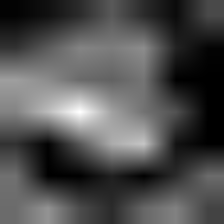

In [20]:
img_ht = Image.fromarray(ht_np)
img_ht

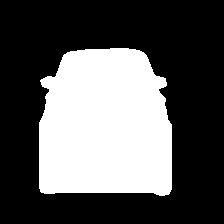

In [21]:
import os 
import glob # glob.glob 는 path를 리스트로 만들어 준다. 
from PIL import Image 

img_pth = './car_data/segmentation/002211.jpg'
img = Image.open(img_pth)
img

In [22]:
img_np = np.asarray(img)
type(img_np)

numpy.ndarray

In [23]:
from CustomFuction.CrossEntropy import CompareFuc

cp = CompareFuc(onetake,img_np)
cp.CrossEntropy_img()


-13186.033134003552

In [24]:
cp.CrossEntropy_np()


3577.6326

In [25]:
cp.intersection()

shape :  (224, 224)


-488269

In [ ]:
cp.intersection_img()

In [26]:
np.log(/np.log(255)

SyntaxError: invalid syntax (1833942788.py, line 1)

In [ ]:
img_np = np.array(img)

r_img = img_np[:,:,2]
print(r_img[125,:])
print(img_np.shape)


[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   4   0   2
   0   2   0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 253 254 255   0   3   2   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
(224, 224, 3)


In [ ]:
np.where(r_img == 0,-1,1) 

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [ ]:
tensor1 = torch.ones(1,1,4,4)
print(tensor1)

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])


In [ ]:
tensor1_255 = 255*tensor1.squeeze()
print(type(tensor1_255))
print(tensor1_255.shape)
tensor1_255


<class 'torch.Tensor'>
torch.Size([4, 4])


tensor([[255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.],
        [255., 255., 255., 255.]])

In [ ]:
tensor1_255_np = np.uint8(tensor1_255)

print(type(tensor1_255_np))
print(tensor1_255_np.shape)
tensor1_255_np

<class 'numpy.ndarray'>
(4, 4)


array([[255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255]], dtype=uint8)

In [ ]:
# cv2.imshow('testimg',tensor1_255_np)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [ ]:
from PIL import Image


seg_img_pix = Image.open('./car_data/segmentation/002211.jpg')

seg_img = torch.from_numpy(np.asarray(seg_img_pix)).permute(2,0,1).float()

seg_img.shape


torch.Size([3, 224, 224])

In [ ]:
seg_img[1].shape

torch.Size([224, 224])

In [ ]:
# import os 
# import glob
# import numpy as np 
# grad_cam_list = [] 
# text_dir = glob.glob('./txt_result_grad_cam/*.txt')
# for i in text_dir:
#     f = open(i,'r')
    
#     grad_cam_list.append(f.read())
# f.close()

In [ ]:
np.asarray(grad_cam_list).shape

NameError: name 'grad_cam_list' is not defined

In [ ]:
np.asarray(grad_cam_list)

array(['[[0.         0.         0.         ... 0.00500743 0.00500743 0.00500743]\n [0.         0.         0.         ... 0.00500743 0.00500743 0.00500743]\n [0.         0.         0.         ... 0.00500743 0.00500743 0.00500743]\n ...\n [0.24338633 0.24338633 0.24338633 ... 0.188556   0.188556   0.188556  ]\n [0.24338633 0.24338633 0.24338633 ... 0.188556   0.188556   0.188556  ]\n [0.24338633 0.24338633 0.24338633 ... 0.188556   0.188556   0.188556  ]]',
       '[[0.34243792 0.34243792 0.34243792 ... 0.2134192  0.2134192  0.2134192 ]\n [0.34243792 0.34243792 0.34243792 ... 0.2134192  0.2134192  0.2134192 ]\n [0.34243792 0.34243792 0.34243792 ... 0.2134192  0.2134192  0.2134192 ]\n ...\n [0.26394114 0.26394114 0.26394114 ... 0.195671   0.195671   0.195671  ]\n [0.26394114 0.26394114 0.26394114 ... 0.195671   0.195671   0.195671  ]\n [0.26394114 0.26394114 0.26394114 ... 0.195671   0.195671   0.195671  ]]',
       '[[0.41637635 0.41637635 0.41637635 ... 0.         0.         0.        ]